In [ ]:
# Install yfinance library
%pip install -q yfinance --upgrade --no-cache-dir
%pip install -q pandas==1.5.3

In [38]:
# Import the necessary libraries
import requests
import pandas as pd
import yfinance as yf
import bs4 as bs
import requests
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

In [2]:
stocks = pd.read_csv("./lib/quarterly_statements.csv",index_col=0, parse_dates=True)

In [3]:
def get_snp_companies(subset='500'):
    WIKI_URL = f"http://en.wikipedia.org/wiki/List_of_S%26P_{subset}_companies"
    resp = requests.get(WIKI_URL)
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text[:-1]
        tickers.append(ticker)

    return tickers

In [4]:
stock_symbols = get_snp_companies('500') + get_snp_companies('400') + get_snp_companies('600')

In [5]:
stocks = stocks.loc['2021-01-01':]
stocks = stocks.loc[stocks.ticker.isin(stock_symbols)]
stocks['end_of_quarter'] = stocks.index

In [ ]:
meta_data = []
N = 1500
for ticker in tqdm(stock_symbols):
  try:
    stock = yf.Ticker(ticker)
    stock_info = stock.info
  except:
    continue
  stock_periods = stocks[stocks.ticker == ticker].index

  if len(stock_periods) < 8:
    print(f'The stock with ticker:{ticker} has less than 8 periods reported')
    continue
  for i in range(len(stock_periods) - 1, -1, -1):
    stock_features = []

    try:
      dividends = stock.dividends[stock_periods[i]- DateOffset(months=3):stock_periods[i]][-1]
    except:
      dividends = np.nan

    try:
      fte = stock_info['fullTimeEmployees']
    except:
      fte = np.nan

    try:
      auditrisk = stock_info['auditRisk']
    except:
      auditrisk = np.nan
    try:
      compensationrisk = stock_info['compensationRisk']
    except:
      compensationrisk = np.nan

    try:
      boardrisk = stock_info['boardRisk']
    except:
      boardrisk = np.nan

    try:
      shareholderrightsrisk = stock_info['shareHolderRightsRisk']
    except:
      shareholderrightsrisk = np.nan
    try:
      maxage = stock_info['maxAge']
    except:
      maxage = np.nan
    try:
      industry = stock_info['industry']
    except:
      industry =  np.nan

    try:
      sector = stock_info['sectorKey']
    except:
      sector = np.nan
    stock_features += [stock_periods[i], ticker, industry, sector, fte, auditrisk, compensationrisk,
                    boardrisk, shareholderrightsrisk, maxage, dividends]
    hist = stock.history(start=stock_periods[i] - DateOffset(months=3), end=stock_periods[i])
    try:
      hist['week_number'] = hist.index.week
    except:
      continue
    weekly_mean_close = hist.groupby('week_number')['Close'].mean()
    stock_features += list(weekly_mean_close.values[:10])
    stock_feature_columns = ['end_of_quarter','ticker', 'industry', 'sector', 'fte', 'auditrisk',
                            'compensationrisk', 'boardrisk', 'shareholderrightsrisk',
                            'maxage', 'dividends'] + [f'weekly_price_{w}' for w in range(len(list(weekly_mean_close.values[:10])))] + ['increase']

    try:
      hist = stock.history(start=stock_periods[i], end=stock_periods[i] + DateOffset(months=3))
      next_quarter_increase = (hist['Close'][-1] - hist['Close'][0]) / hist['Close'][0]
      stock_features += [next_quarter_increase]
      meta_data.append(stock_features)
    except:
      continue
  if N < 0:
    break
  N -= 1

In [ ]:
# meta_df = pd.DataFrame(meta_data, columns=stock_feature_columns)
# meta_df.to_csv('/content/drive/MyDrive/Colab Notebooks/stocks/meta_df_2020.csv', index=False)

In [6]:
meta_df = pd.read_csv('meta_df_2020.csv')
meta_df.end_of_quarter = pd.to_datetime(meta_df.end_of_quarter)
df = pd.merge(stocks, meta_df, how='left', on=['ticker', 'end_of_quarter'])

In [ ]:
# df.to_csv('stocks_processed_2020.csv', index=False)

In [62]:
df = pd.read_csv('stocks_processed_2020.csv')

In [63]:
# selecting only numerical features, we need them for normalization, etc. 'increase' is also a numerical, but we dont modify it since it is our target
numerical_features = list(df.columns)
numerical_features.remove('ticker')
numerical_features.remove('end_of_quarter')
numerical_features.remove('industry')
numerical_features.remove('sector')
numerical_features.remove('increase')

In [64]:
# we take all data since 2021 (we skip earlier years due covid effects) 
df = df.loc[df.end_of_quarter > '2021-01-01']

In [65]:
df['end_of_quarter'] = pd.to_datetime(df['end_of_quarter'])
df['quarter_year'] = df['end_of_quarter'].dt.to_period('Q')

In [66]:
# remove commas from thousands, and replace values that have only '-' with nan
tmp = df['end_of_quarter'].copy()
for col in list(df.columns):
  try:
    df.loc[:, col] = df.loc[:, col].str.replace(',', '').replace(r'^-$', np.nan, regex=True)
  except:
    pass
# all percentage columns, remove the percent sign
percentage_columns = [col for col in df.columns if any(df[col].astype(str).str.contains('%'))]
for col in percentage_columns:
  df.loc[:, col] = df.loc[:, col].str.replace('%', '')
df['end_of_quarter'] = tmp

In [67]:
# converting all numerical values from string to float
df[numerical_features + ["increase"]] = df[numerical_features + ["increase"]].astype('float')

In [68]:
# Mean normalization of all numerical values. As suggested by finance experts, we take the mean and the standard deviation of the industry per quarter for normalization
df_mean = df.groupby(['quarter_year', 'industry']).mean()
df_std = df.groupby(['quarter_year', 'industry']).std()
dff = pd.merge(left=df, right=df_mean, how='left', on=['quarter_year', 'industry'], suffixes=["", "_mean"])
dff = pd.merge(left=dff, right=df_std, how='left', on=['quarter_year', 'industry'], suffixes=["", "_std"])

for col in numerical_features:
  dff[col] = (dff[col] - dff[col + "_mean"]) / dff[col + "_std"]
df = dff

In [69]:
# One hot encoding of industry, we skip encoding of sector since we have almost all NaNs there
one_hot_encoded_industry = pd.get_dummies(df['industry'], prefix='industry')
# one_hot_encoded_sector = pd.get_dummies(df['sector'], prefix='sector')
df = pd.concat([df, one_hot_encoded_industry], axis=1)
df.drop(['industry', 'sector'], axis=1, inplace=True)

In [70]:
df.increase.max(), df.increase.min()

(3.287690168494993, -0.7172177799983862)

In [71]:
# where target variable 'increase' does not exists, remove those rows
df.dropna(axis=0, inplace=True, subset=['increase'])

In [72]:
# train test split (we leave the last quarter for test)
df_test = df.groupby('ticker', as_index=False).first()
df_train = df.loc[~df.end_of_quarter.isin(list(df_test.end_of_quarter.values))]
df_train.shape, df_test.shape

((14971, 569), (1486, 569))

In [73]:
y_train = df_train[['increase', 'ticker']]
y_test = df_test[['increase', 'ticker']]
df_test = df_test.drop(['ticker', 'end_of_quarter', 'increase', 'quarter_year'], axis=1)
df_train = df_train.drop(['ticker', 'end_of_quarter', 'increase',  'quarter_year'], axis=1)

In [74]:
# going from real valued 'increase' to classification problem
y_train['increase_real_values'] = y_train.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
y_train.increase[y_train.increase_real_values >= class_thresholds[3]] = 4
y_train.increase[(y_train.increase_real_values >= class_thresholds[2]) & (y_train.increase_real_values < class_thresholds[3])] = 3
y_train.increase[(y_train.increase_real_values >= class_thresholds[1]) & (y_train.increase_real_values < class_thresholds[2])] = 2
y_train.increase[(y_train.increase_real_values > class_thresholds[0]) & (y_train.increase_real_values < class_thresholds[1])] = 1
y_train.increase[y_train.increase_real_values <= class_thresholds[0]] = 0

In [75]:
class_counts = dict(zip(*np.unique(y_train.increase.values, return_counts=True)))
class_weights = {class_label: len(y_train.increase.values) / (len(np.unique(y_train.increase.values)) * count) for class_label, count in class_counts.items()}
class_counts, class_weights

({0.0: 3541, 1.0: 3963, 2.0: 3723, 3.0: 2158, 4.0: 1586},
 {0.0: 0.845580344535442,
  1.0: 0.7555387332828665,
  2.0: 0.8042438893365565,
  3.0: 1.3874884151992586,
  4.0: 1.8878940731399747})

In [76]:
# We fill all NaN values with maxint from numpy. Currently, we are not sure if this is financially correct (?)
df_train.fillna(np.iinfo('int').max, inplace=True)
df_test.fillna(np.iinfo('int').max, inplace=True)

In [77]:
# Assuming you have your features (x) and labels (y) ready, split the data.
X_train, X_test, Y_train, Y_test = train_test_split(df_train, y_train, test_size=0.1, random_state=42)

In [78]:
# We fit a classifier to predict the increase in percentage into the next Q
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)#, class_weight=class_weights)
# Fit the model to the training data
rf_classifier.fit(X_train, Y_train.increase)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [79]:
# Predict on the test set just as sanity check
rf_classifier.predict(X_test)
ticker = Y_test.ticker
p = pd.DataFrame({"ticker": ticker, "preds": rf_classifier.predict(X_test), "true": Y_test.increase, "increase": Y_test.increase_real_values})
# Select the top K stocks that we would invest (still this data is older, just for sanity check and to check for underfitting)
K = 10
p.sort_values(by='preds')[::-1].iloc[:K]

,ticker,preds,true,increase
14552,GPS,4.0,3.0,0.171251
5671,VRSK,4.0,1.0,-0.011692
3080,COKE,4.0,2.0,0.097936
1137,SNEX,4.0,1.0,-0.061609
5591,DV,4.0,4.0,0.271642
17767,WAT,4.0,0.0,-0.118406
2992,AMPH,4.0,4.0,0.490933
8285,HES,4.0,4.0,0.466433
7144,SM,4.0,4.0,0.377205
8016,ELF,4.0,4.0,0.480064


In [80]:
# Distribution sanity check
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.true.value_counts().values})

,value,pred_counts,true_counts
0,1.0,434,411
1,2.0,423,359
2,0.0,407,357
3,4.0,119,216
4,3.0,115,155


In [81]:
# Compute accuracy
accuracy = accuracy_score(p.true, p.preds)
print("Accuracy:", accuracy)
print(f'Confusion matrix: \n {confusion_matrix(p.true, p.preds)}')

Accuracy: 0.4032042723631509
Confusion matrix: 
 [[196 101  38  11  13]
 [ 96 177 103  20  15]
 [ 52  94 157  35  19]
 [ 33  41  88  28  26]
 [ 30  21  37  21  46]]


In [82]:
proba = rf_classifier.predict_proba(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))])[rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))])== np.max(rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]))][:, -1]
# predicting on the SNP 500 stocks
p = pd.DataFrame({"ticker": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].ticker, "preds": rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]), "increase": y_test.increase.loc[y_test.ticker.isin(get_snp_companies('500'))]})
# selecting the top K stocks we want to put money in
p[p.preds == np.max(p.preds.values)]
b = p[p.preds == np.max(p.preds.values)]
b['proba'] = proba
b.sort_values(by='proba')[::-1].iloc[:10]

,ticker,preds,increase,proba
90,ANET,4.0,0.319264,0.315
1257,STX,4.0,0.040061,0.297
1050,PHM,4.0,0.149138,0.265
290,CMG,4.0,0.295400,0.258
1422,WDC,4.0,0.247279,0.256
1218,SMCI,4.0,2.732703,0.245


In [83]:
f'We have gain (positive) or loss (negative) of {b.sort_values(by="proba")[::-1].iloc[:10].increase.mean()  * 100}% on the invested 10 stocks'

'We have gain (positive) or loss (negative) of 63.0640891829923% on the invested 10 stocks'

In [84]:
p['increase_q'] = p.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
p.increase_q[p.increase >= class_thresholds[3]] = 4
p.increase_q[(p.increase >= class_thresholds[2]) & (p.increase < class_thresholds[3])] = 3
p.increase_q[(p.increase >= class_thresholds[1]) & (p.increase < class_thresholds[2])] = 2
p.increase_q[(p.increase > class_thresholds[0]) & (p.increase < class_thresholds[1])] = 1
p.increase_q[p.increase <= class_thresholds[0]] = 0

In [85]:
# Compute accuracy on test
accuracy = accuracy_score(p.increase_q, p.preds)
print("Accuracy on test set:", accuracy)
print(f'Confusion matrix on test set: \n {confusion_matrix(p.increase_q, p.preds)}')

Accuracy on test set: 0.3246492985971944
Confusion matrix on test set: 
 [[18 18  7  0  0]
 [18 65 38  0  0]
 [17 62 74  6  1]
 [12 34 61  1  1]
 [ 8 21 30  3  4]]


<Figure size 1600x1600 with 0 Axes>

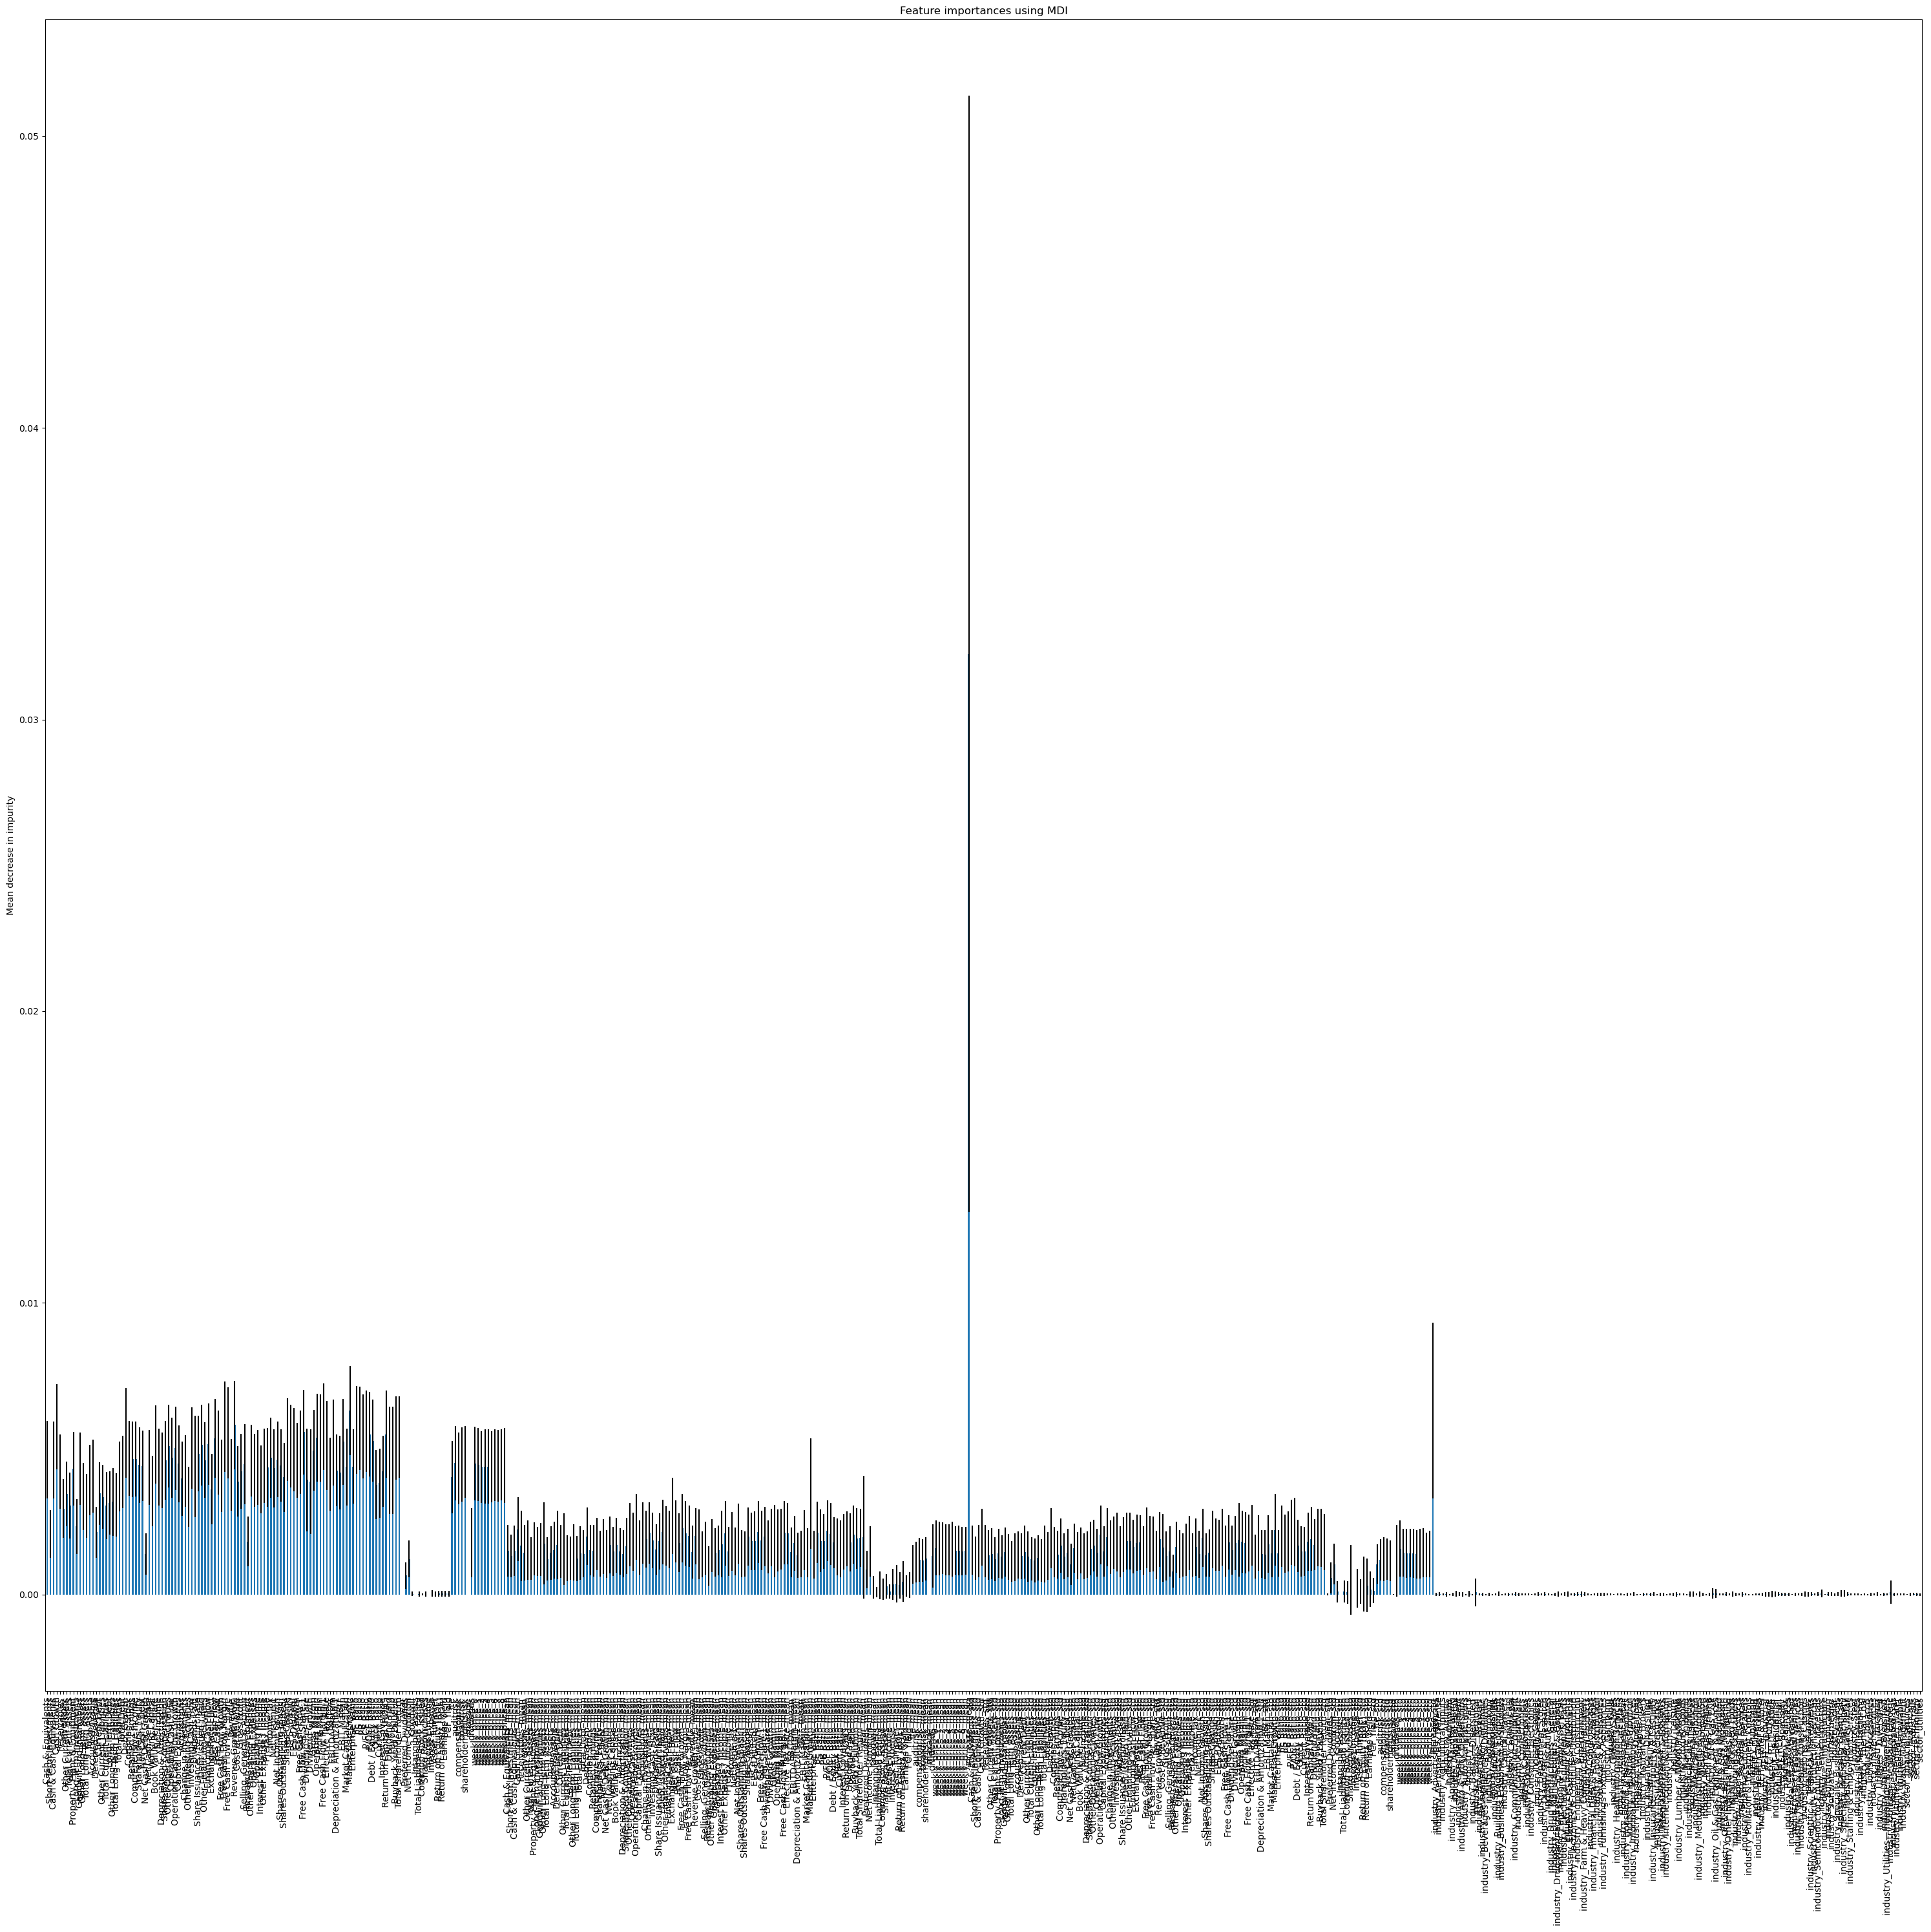

In [37]:
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=list(df_train.columns))
plt.figure(figsize=(16,16))
fig, ax = plt.subplots(figsize=(30,30))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('feature_importances_plot.png')